In [1]:
import pandas as pd
import numpy as np
import os
import re
import sklearn
from pathlib import Path
from langdetect import detect_langs

import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv("../tos_data/privacy_policy_data.csv", error_bad_lines=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Length    183 non-null    int64 
 1   Link      183 non-null    object
 2   Original  182 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.4+ KB


In [2]:
def remove_multiple_space(sentence):
    clear_sentence = ' '.join(sentence.split())
    #clear_sentence = clear_sentence.lower()
    return clear_sentence

df_raw = df[df['Length'] > 300] # Deleting a HTML's text that was not properly collected.
df_raw['Original'] = df_raw['Original'].astype(str)
df_raw = df_raw.drop_duplicates(['Original'])
df_raw['Original'] = df_raw['Original'].apply(remove_multiple_space)
df_raw.describe(include=object)

<ipython-input-2-1bb8b5900bb7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['Original'] = df_raw['Original'].astype(str)


,Link,Original
count,181,181
unique,181,181
top,https://www.hbomax.com/privacy,Privacy Policy HOME FORECAST Local Graphical A...
freq,1,1


In [3]:
df_raw = df_raw.drop(columns=['Length'])

def split_sentence(s):
    t_list = re.split(r'[.;]\s*(?=[A-Z])', s)

    return t_list

def filter_roman_number(s):
    result = []
    for t in s:
        t_result = re.split(r'\(.\) | \(..\) | \(...\) | \(....\)', t)
        result = result + t_result
        
    result = list(filter(None, result))  
    return result

def make_new_row(plist, df_raw_parsed):
    for s in plist:
        new_row = {
            'Link': row['Link'],
            'Original': s,
        }
        df_raw_parsed = df_raw_parsed.append(new_row, ignore_index=True)
    return df_raw_parsed

df_raw_parsed = pd.DataFrame(columns=['Link', 'Original'])
for i, row in df_raw.iterrows():
    t_list = split_sentence(row['Original'])
    f_list = filter_roman_number(t_list)

    if not f_list:
        df_raw_parsed = make_new_row(t_list, df_raw_parsed)
    else:
        df_raw_parsed = make_new_row(f_list, df_raw_parsed)



In [4]:
df_raw_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37187 entries, 0 to 37186
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Link      37187 non-null  object
 1   Original  37187 non-null  object
dtypes: object(2)
memory usage: 581.2+ KB


In [5]:
df_raw_parsed['Length'] = df_raw_parsed['Original'].apply(lambda x: len(x)) # Create new 'Length' column.
df_raw_parsed = df_raw_parsed[['Length', 'Link', 'Original']]
df_raw_parsed = df_raw_parsed[df_raw_parsed['Length'] > 50]

In [6]:
df_raw_parsed.describe(include=object)

,Link,Original
count,32229,32229
unique,181,28679
top,https://privacy.microsoft.com/en-us/privacysta...,"If you do not allow these cookies, you will ex..."
freq,2932,15


In [7]:
df_raw_parsed['Original'] = df_raw_parsed['Original'].astype(str)
df_raw_parsed = df_raw_parsed.drop_duplicates(['Original']) # Remove duplicate data. Remain unique data in column.
df_raw_parsed.describe(include=object)

,Link,Original
count,28679,28679
unique,181,28679
top,https://privacy.microsoft.com/en-us/privacysta...,Technical InformationBy generally visiting or ...
freq,1476,1


In [8]:
def detect_english_sentence(sentence):
    res = detect_langs(sentence)
    for item in res:
        if item.lang == "en" and item.prob > 0.99:
            return True
        else:
            return False

def make_space(sentence):
    result =[]
    # Insert a space such as "HelloWorld" -> "Hello World"
    result = re.sub(r"([a-z])([A-Z])([a-z])", r"\1 \2\3", sentence)
    return result

for i, row in df_raw_parsed.iterrows():
    if detect_english_sentence(row['Original']) == True:
        result = make_space(row['Original'])
    else:
        result = ""
    df_raw_parsed.loc[i, 'Original'] = result

In [9]:
df_raw_parsed = df_raw_parsed.reset_index(drop=True)
df_raw_parsed = df_raw_parsed[df_raw_parsed['Original'] != '']

In [10]:
# df_raw_parsed.to_csv(Path(os.getcwd() + "/" + "test_pp_data.csv"), index=False) 

In [11]:
# Compare data that calculated length of whole sentence each pandas.
# Through this, you can see how much data is lost after parsing.

# df_raw = df_raw[df_raw['Original'] != '']
# df_raw['Original'] = df_raw['Original'].astype(str)
# df_raw = df_raw.drop_duplicates(['Original'])

# sum_df_raw = 0
# sum_df_raw_parsed = 0

# for i, row in df_raw.iterrows():
#     sum_df_raw = sum_df_raw + len(row['Original'])

# for i, row in df_raw_parsed.iterrows():
#     sum_df_raw_parsed = sum_df_raw_parsed + len(row['Original'])

# print('Before text parsing {0}, After text parsing {1}'.format(sum_df_raw, sum_df_raw_parsed))

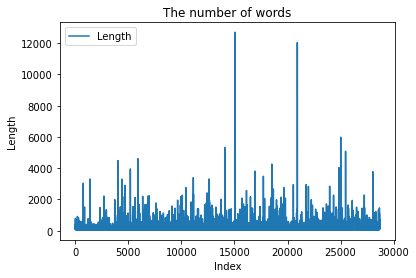

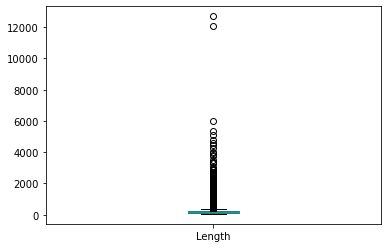

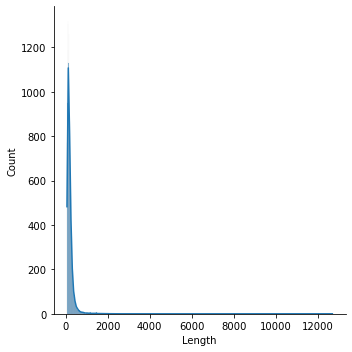

In [12]:
plt.title("The number of words")
plt.xlabel("Index")
plt.ylabel("Length")
plt.plot(df_raw_parsed.index, df_raw_parsed['Length'].values, label='Length')
plt.legend(loc='upper left')
plt.show()
df_raw_parsed.plot(kind='box', figsize=(6,4))
sns.displot(df_raw_parsed['Length'], kde=True)
# Reference: https://datascienceschool.net/01%20python/05.04%20%EC%8B%9C%EB%B3%B8%EC%9D%84%20%EC%82%AC%EC%9A%A9%ED%95%9C%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%B6%84%ED%8F%AC%20%EC%8B%9C%EA%B0%81%ED%99%94.html

In [13]:
df_raw_parsed.describe(exclude=object)

,Length
count,28258.000000
mean,191.974450
std,222.485662
min,51.000000
25%,103.000000
50%,149.000000
75%,217.000000
max,12701.000000


In [14]:
df_heuristics = pd.read_csv("test_pp_data.csv", error_bad_lines=False)
df_heuristics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28204 entries, 0 to 28203
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Length    28204 non-null  int64 
 1   Link      28204 non-null  object
 2   Original  28204 non-null  object
dtypes: int64(1), object(2)
memory usage: 661.2+ KB


In [15]:
df_heuristics = df_heuristics.sort_values(by='Length') # data sorted by descending order.
df_heuristics = df_heuristics.reset_index(drop=True)
df_heuristics

,Length,Link,Original
0,51,https://www.nytimes.com/privacy/privacy-policy,This helps us make business and marketing deci...
1,51,https://www.netskope.com/privacy-policy,This is used for analytical purposes on the we...
2,51,https://www.crazylabs.com/apps-privacy-policy/,These Third Party ad networks may collect and ...
3,51,https://stripe.com/privacy,Creation and management of Stripe Checkout acc...
4,51,https://www.cohesity.com/legal/privacy/,"As such, we may amend this Policy from time to..."
...,...,...,...
28199,5086,https://www.tribpub.com/privacy-policy/,How we share and disclose user information wit...
28200,5332,https://www.condenast.com/privacy-policy,Category of Personal Information Categories of...
28201,5987,https://pmc.com/privacy-policy/,Information you provide to us: Categories of i...
28202,12045,https://docs.github.com/en/github/site-policy/...,Git Hub Privacy Statement - Git Hub Docs Git H...


In [16]:
np.percentile(df_heuristics['Length'], [5, 95], interpolation='nearest') # For readability, extract sentences based on 5%ile, 95%ile.

array([ 65, 417], dtype=int64)

In [17]:
df_heuristics = df_heuristics[(df_heuristics['Length'] >= 65) & (df_heuristics['Length'] <= 417)]
df_heuristics

,Length,Link,Original
1399,65,https://www.appsflyer.com/legal/privacy-policy/,The right to access certain information about ...
1400,65,https://www.helpguide.org/privacy-policy.htm,"At this time, we do not respond to browser “Do..."
1401,65,https://mailchimp.com/legal/privacy/,You can learn more about Courier and its priva...
1402,65,https://www.bitmango.com/privacy-policy/,Our customer service channel is found at http:...
1403,65,https://mailchimp.com/legal/privacy/,"If we are unable to remove your information, w..."
...,...,...,...
26798,417,https://docs.bugsnag.com/legal/privacy-policy/,Scope# This Privacy Policy applies to Personal...
26799,417,https://www.cohesity.com/legal/privacy/,To process or personalize our interaction with...
26800,417,https://georgia.gov/privacysecurity,Facebook page for Georgia.gov Twitter page for...
26801,417,https://www.spotify.com/us/legal/privacy-policy/,The table below describes personal data that y...


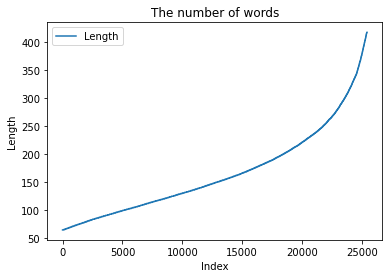

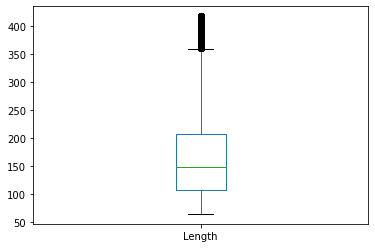

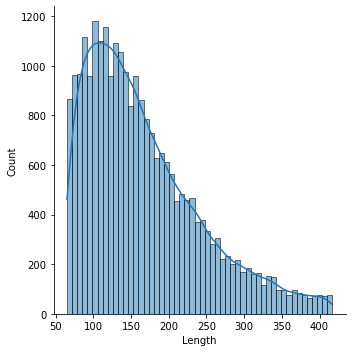

In [18]:
df_heuristics = df_heuristics.reset_index(drop=True)

plt.title("The number of words")
plt.xlabel("Index")
plt.ylabel("Length")
plt.plot(df_heuristics.index, df_heuristics['Length'].values, label='Length')
plt.legend(loc='upper left')
plt.show()
df_heuristics.plot(kind='box', figsize=(6,4))
sns.displot(df_heuristics['Length'], kde=True)

In [19]:
df_mturk = sklearn.utils.shuffle(df_heuristics)
df_mturk = df_mturk.drop(columns=['Length'])

In [20]:
df_mturk_tos = pd.read_csv("mturk_tos_data_include_length.csv", error_bad_lines=False)
df_mturk_tos = df_mturk_tos.drop(columns=['Length'])
df_mturk_tos.info() # ToS and T&C data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46221 entries, 0 to 46220
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Link      46221 non-null  object
 1   Original  46221 non-null  object
dtypes: object(2)
memory usage: 722.3+ KB


In [21]:
df_mturk_tos = df_mturk_tos[600:] # 600 sentences completed before, have to remove the first 600 sentences.
df_mturk_tos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45621 entries, 600 to 46220
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Link      45621 non-null  object
 1   Original  45621 non-null  object
dtypes: object(2)
memory usage: 713.0+ KB


In [22]:
df_mturk.info() # privacy policy data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25404 entries, 19690 to 3768
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Link      25404 non-null  object
 1   Original  25404 non-null  object
dtypes: object(2)
memory usage: 595.4+ KB


In [23]:
df_mturk_concat = pd.concat([df_mturk_tos, df_mturk])
df_mturk_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71025 entries, 600 to 3768
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Link      71025 non-null  object
 1   Original  71025 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [24]:
df_mturk_final = sklearn.utils.shuffle(df_mturk_concat)

In [25]:
df_mturk_final_10000 = df_mturk_final.sample(n=10000)
df_mturk_final_10000.to_csv(Path(os.getcwd() + "/" + "mturk_tos10000_data.csv"), index=False)